# LSTM 활용한 삼성전자 주가 예측

## <span style="font-size:25px">개발 과정 - 시계열 데이터 분석 및 예측</span>

<dl>
<dt style="font-size:20px">▶ 데이터 로드 및 분포 확인</dt>
<dd style="font-size:18px">
✔ dt=pd.read_csv(), df.describe(), df.hist(), plot() 등
</dd>

<br>
<dt style="font-size:20px">▶ 데이터 전처리</dt>
<dd style="font-size:18px">
✔ outlier / missing value 확인 후 대체(또는 삭제) 처리
<br>
<br>✔ 데이터 정규화(normalization) / 표준화(standardization)
<br>
<br>✔ 딥러닝 학습을 위한 feature column / label column 정의
</dd>

<br>
<dt style="font-size:20px">▶ 데이터 생성</dt>
<dd style="font-size:18px">
✔ window size 설정 후 feature / label 시계열 데이터 생성
<br>
<br>✔ 학습 데이터 생성. 이때 입력 데이터는 (batch_size, time_step, 
<br>　 input_dims) 형태의 3차원 텐서로 생성되어야 함
</dd>

<br>
<dt style="font-size:20px">▶ 순환신경망 모델 구축 및 학습</dt>
</dl>

### <span style="font-size:25px">데이터 로드 및 분포확인</span>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
raw_df = pd.read_csv('./datafile/삼성전자_MA3_MA5.csv')
raw_df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,MA3,MA5
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4375.398926,74195000,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,3995.864990,74680000,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4024.508301,54390000,5770.000000,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,3967.220947,40305000,5580.000000,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4131.925293,46880000,5643.333333,5724.0


C:\Users\skygr\AppData\Local\Temp\ipykernel_41940\4086856907.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


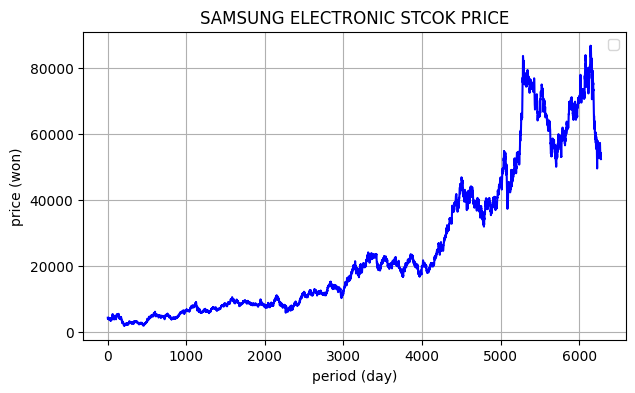

In [15]:
plt.figure(figsize=(7, 4))

plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.xlabel('period (day)')
plt.ylabel('price (won)')
plt.legend(loc='best')
plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')
plt.grid()
plt.show()

#### <span style="font-size:20px">데이터 불러온 후 저장</span>

In [5]:
# loaded the samsung data
df = fdr.DataReader(f'YAHOO:005930.KS', '2000-01-01', '2025-02-01')
display(df)

,Open,High,Low,Close,Volume,Adj Close
2000-01-04,6000.0,6110.0,5660.0,6110.0,74195000,4375.398926
2000-01-05,5800.0,6060.0,5520.0,5580.0,74680000,3995.864990
2000-01-06,5750.0,5780.0,5580.0,5620.0,54390000,4024.508301
2000-01-07,5560.0,5670.0,5360.0,5540.0,40305000,3967.220947
2000-01-10,5600.0,5770.0,5580.0,5770.0,46880000,4131.925293
...,...,...,...,...,...,...
2025-01-21,53700.0,54300.0,53300.0,53500.0,13535702,53500.000000
2025-01-22,53400.0,54400.0,53100.0,54300.0,18341991,54300.000000
2025-01-23,53700.0,54100.0,53500.0,53700.0,15588067,53700.000000
2025-01-24,53600.0,53800.0,53200.0,53700.0,11867631,53700.000000


In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
df['MA3'] = df['Close'].rolling(window=3).mean()    # 3일 선
df['MA5'] = df['Close'].rolling(window=5).mean()    # 5일 선

df.to_csv('./datafile/삼성전자_MA3_MA5.csv')
df

C:\Users\skygr\AppData\Local\Temp\ipykernel_41940\1524830818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA3'] = df['Close'].rolling(window=3).mean()    # 3일 선


,Open,High,Low,Close,Adj Close,Volume,MA3,MA5
2000-01-04,6000.0,6110.0,5660.0,6110.0,4375.398926,74195000,NaN,NaN
2000-01-05,5800.0,6060.0,5520.0,5580.0,3995.864990,74680000,NaN,NaN
2000-01-06,5750.0,5780.0,5580.0,5620.0,4024.508301,54390000,5770.000000,NaN
2000-01-07,5560.0,5670.0,5360.0,5540.0,3967.220947,40305000,5580.000000,NaN
2000-01-10,5600.0,5770.0,5580.0,5770.0,4131.925293,46880000,5643.333333,5724.0
...,...,...,...,...,...,...,...,...
2025-01-21,53700.0,54300.0,53300.0,53500.0,53500.000000,13535702,53533.333333,53720.0
2025-01-22,53400.0,54400.0,53100.0,54300.0,54300.000000,18341991,53733.333333,53840.0
2025-01-23,53700.0,54100.0,53500.0,53700.0,53700.000000,15588067,53833.333333,53720.0
2025-01-24,53600.0,53800.0,53200.0,53700.0,53700.000000,11867631,53900.000000,53720.0


### <span style="font-size:22px">데이터 전처리</span>

#### <span style="font-size:20px">Outlier 확인</span>

<dl>
<dt style="font-size:18px">▶ 통계적으로 비정상적인, 즉 크거나 작은 데이터 값, outlier(특이값)은 딥러닝 학습을 
<br>　 하기 위해서 적절한 값으로 바꾸거나 삭제하는 등의 처리가 반드시 필요함
</dt><br>
<dd style="font-size:16px">
- 판다스 describe()를 통해서 삼전 주가 데이터 통계를 확인하면, 거래량을 나타내는 
<br>　Volume 최소값이 0임을 알 수 있음 => 주식과 같은 금융 데이터에서 Volume(거래량) 
<br>　값이 없는, 즉 0으로 나타나는 곳은 missing value(결측값)인 NaN으로 취급하는 것이 일반적임
</dd>
</dl>

In [16]:
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,MA3,MA5
count,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6.279000e+03,6277.000000,6275.000000
mean,29283.811116,29570.530339,28987.069597,29271.931836,25095.015640,2.121070e+07,29271.896341,29271.774980
std,23131.343268,23318.071765,22926.570965,23106.698367,22403.570527,1.495452e+07,23102.926397,23099.749909
min,2540.000000,2760.000000,2420.000000,2730.000000,1954.966187,0.000000e+00,2790.000000,2810.000000
25%,10900.000000,11010.000000,10720.000000,10870.000000,7862.830078,1.175648e+07,10880.000000,10884.000000
50%,22580.000000,22820.000000,22360.000000,22620.000000,17657.097656,1.725595e+07,22626.666667,22672.000000
75%,46810.000000,47200.000000,46300.000000,46850.000000,39343.308594,2.627057e+07,46766.666667,46689.000000
max,90300.000000,96800.000000,89500.000000,91000.000000,86718.812500,1.642150e+08,90433.333333,89960.000000


#### <span style="font-size:20px">Missing Value 확인</span>

<dl>
<dt style="font-size:18px">▶ 결측치(missing value)는 특정 데이터가 누락된 것을 말하며, outlier와 마찬가지로 
<br>　 이러한 missing value를 제거하거나 적절한 값으로 대체하는 등의 처리가 필요함
</dt><br>
<dd style="font-size:16px">
- 판다스 isnull().sum() 통해서 삼전 주가 데이터의 missing value를 확인해보면, 6개의 
<br>　칼럼(Open, High, Low, Close, Adj Close, Volume)에서 각각 6개 missing value가 있음을  
<br>　알 수 있음 => 주식과 같은 금융 데이터에서 NaN으로 표시되는 missing value는 평균값이나 
<br>　중간값 등으로 대체하지 않고 해당되는 행(row) 전체를 삭제하는 것이 일반적임
</dd>
</dl>

In [19]:
raw_df.isnull().sum()

Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA3           2
MA5           4
dtype: int64

In [20]:
raw_df.loc[raw_df['Open'].isna()]

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,MA3,MA5


#### <span style="font-size:20px">Outlier 및 Missing Value 처리</span>

In [21]:
# Volume 값 0을 NaN으로 모두 대체(replace)
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Unnamed: 0: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
MA3: 0
MA5: 0


In [22]:
# 모든 Missing Value 삭제
raw_df.isnull().sum()

Unnamed: 0      0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume        127
MA3             2
MA5             4
dtype: int64

In [23]:
raw_df = raw_df.dropna()
raw_df.isnull().sum()

Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA3           0
MA5           0
dtype: int64

#### <span style="font-size:25px">정규화(Normalization)</span>

In [25]:
# 딥러닝 학습이 잘 되기 위해서는 정규화 작업이 필요함. 즉 날짜를 나타내는 Date
# 항목을 제외한 숫자로 표현되는 모든 column에 대해서 0~1 값으로 정규화 수행함
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 
              'MA3', 'MA5', 'Volume']                   # 정규화 대상 column 정의
scaled_df = scaler.fit_transform(raw_df[scale_cols])    # 정규화 수행
print(type(scaled_df),'\n')
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

<class 'numpy.ndarray'> 

          Open      High       Low  ...       MA3       MA5    Volume
0     0.034868  0.032008  0.036288  ...  0.032556  0.033215  0.285359
1     0.037375  0.035517  0.038470  ...  0.033127  0.032434  0.363715
2     0.034982  0.031689  0.036518  ...  0.033811  0.032756  0.177799
3     0.034868  0.031689  0.036059  ...  0.033583  0.032962  0.250704
4     0.036235  0.033177  0.037437  ...  0.033811  0.033628  0.300555
...        ...       ...       ...  ...       ...       ...       ...
6143  0.582954  0.548065  0.584290  ...  0.578975  0.584070  0.082272
6144  0.579535  0.549128  0.581994  ...  0.581257  0.585447  0.111545
6145  0.582954  0.545938  0.586587  ...  0.582398  0.584070  0.094772
6146  0.581814  0.542748  0.583142  ...  0.583159  0.584070  0.072113
6147  0.565861  0.534241  0.565916  ...  0.575933  0.581774  0.256771

[6148 rows x 8 columns]


#### <span style="font-size:25px">feature column / label column 정의</span>

In [26]:
# 딥러닝 학습을 위한 입력 데이터 feature column, 정답 데이터 label column 정의 후 
# numpy로 변환하여 데이터 전처리 과정을 완료함

feature_cols = ['MA3', 'MA5', 'Adj Close']
label_cols   = ['Adj Close']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df   = pd.DataFrame(scaled_df, columns=label_cols)

print(feature_df)
print(label_df)

feature_np = feature_df.to_numpy()
label_np   = label_df.to_numpy()

           MA3       MA5  Adj Close
0     0.032556  0.033215   0.025683
1     0.033127  0.032434   0.025683
2     0.033811  0.032756   0.025260
3     0.033583  0.032962   0.025176
4     0.033811  0.033628   0.026190
...        ...       ...        ...
6143  0.578975  0.584070   0.608102
6144  0.581257  0.585447   0.617540
6145  0.582398  0.584070   0.610461
6146  0.583159  0.584070   0.610461
6147  0.575933  0.581774   0.595124

[6148 rows x 3 columns]
      Adj Close
0      0.025683
1      0.025683
2      0.025260
3      0.025176
4      0.026190
...         ...
6143   0.608102
6144   0.617540
6145   0.610461
6146   0.610461
6147   0.595124

[6148 rows x 1 columns]


### <span style="font-size:25px">데이터 생성 - 입력 데이터 feature/정답 데이터 label</span>

In [27]:
def make_sequene_dataset(feature, label, window_size):
    feature_list, label_list = [], []
    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list)

In [28]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(6108, 40, 3) (6108, 1)


### <span style="font-size:25px">데이터 분리 및 모델 구축</span>

In [32]:
split = -200

x_train = X[0:split]
t_train = Y[0:split]

x_test = X[split:]
t_test = Y[split:]

print(x_train.shape, t_train.shape, 
      x_test.shape, t_test.shape)

(5908, 40, 3) (5908, 1) (200, 40, 3) (200, 1)
(40, 3)


In [33]:
model = Sequential()

model.add(LSTM(128, 
               activation='tanh', 
               input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)      # 1e-5이하이면  학습 정지

model.fit(x_train, t_train, epochs=100, validation_data=(x_test, t_test), batch_size=16, callbacks=[early_stop])

Epoch 1/100
370/370 [==============================] - 15s 7ms/step - loss: 0.0015 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 2/100
370/370 [==============================] - 2s 6ms/step - loss: 1.7781e-04 - mae: 0.0082 - val_loss: 9.4692e-04 - val_mae: 0.0240
Epoch 3/100
370/370 [==============================] - 2s 6ms/step - loss: 1.7327e-04 - mae: 0.0083 - val_loss: 9.3128e-04 - val_mae: 0.0233
Epoch 4/100
370/370 [==============================] - 2s 6ms/step - loss: 1.5230e-04 - mae: 0.0078 - val_loss: 8.2811e-04 - val_mae: 0.0228
Epoch 5/100
370/370 [==============================] - 2s 5ms/step - loss: 1.2401e-04 - mae: 0.0070 - val_loss: 7.1380e-04 - val_mae: 0.0205
Epoch 6/100
370/370 [==============================] - 2s 6ms/step - loss: 1.2111e-04 - mae: 0.0071 - val_loss: 7.7780e-04 - val_mae: 0.0218
Epoch 7/100
370/370 [==============================] - 2s 6ms/step - loss: 1.0754e-04 - mae: 0.0067 - val_loss: 6.0552e-04 - val_mae: 0.0188
Epoch 8/100
370/370 

7/7 [==============================] - 0s 38ms/step


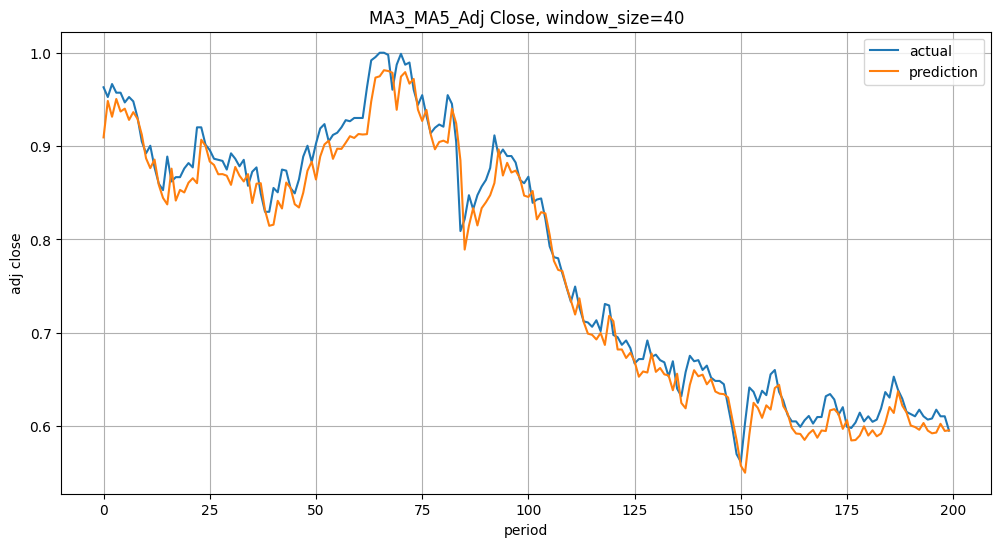

In [37]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('MA3_MA5_Adj Close, window_size=40')
plt.xlabel('period')
plt.ylabel('adj close')
plt.plot(t_test, label='actual')
plt.plot(pred, label='prediction')
plt.legend(loc='best')
plt.grid()
plt.show()